In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [2]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1281 non-null   object 
 1   label     1281 non-null   object 
 2   offset    1281 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


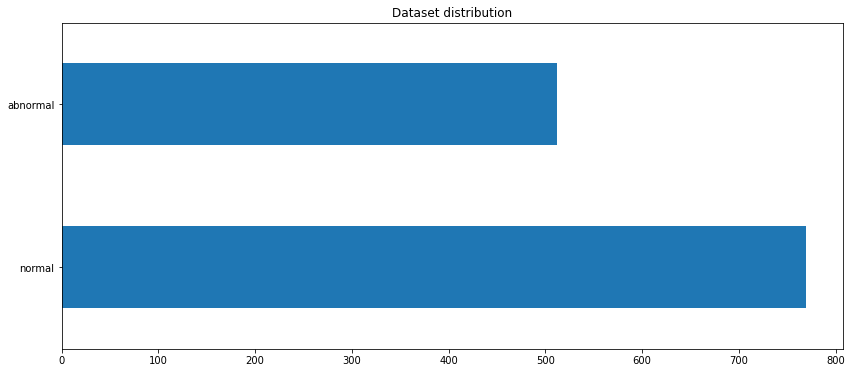

In [6]:
plt.figure(figsize=(14,6))
dataset.label.value_counts().plot(kind='barh', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [7]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1024
Test: 257


## Visualising the data and features

./set_b\normal__137_1306764999211_C.wav
./set_b\extrastole__220_1308250132896_B.wav


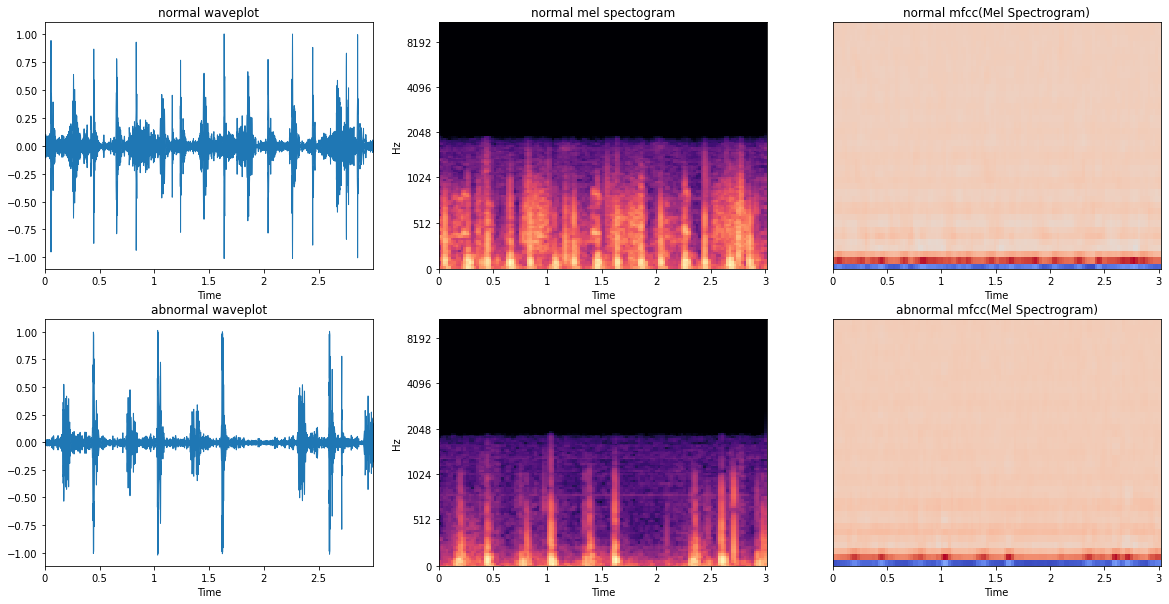

In [8]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [9]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [10]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 257/257 [00:38<00:00,  6.63it/s]X train: (1024, 40, 130)
X test: (257, 40, 130)



In [11]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
print(np.unique(y_train))

class_test = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {0:class_test[0],1:class_test[1]}
print(class_weights)
print(type(class_weights))

[0 1]
{0: 1.2673267326732673, 1: 0.8258064516129032}
<class 'dict'>


## Input Shapes

In [12]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1024, 40, 130, 1)
Y train: (1024, 2)
X test: (257, 40, 130, 1)
Y test: (257, 2)


## Building Model

In [13]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 31, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 30, 64)         8

## Compiling Model

In [14]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Fitting Model

In [15]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)

Epoch 1/300
8/8 [==============================] - 1s 168ms/step - loss: 9.0933 - accuracy: 0.4785 - val_loss: 1.8705 - val_accuracy: 0.5798
Epoch 2/300
8/8 [==============================] - 0s 51ms/step - loss: 3.4805 - accuracy: 0.5273 - val_loss: 2.4239 - val_accuracy: 0.4202
Epoch 3/300
8/8 [==============================] - 0s 48ms/step - loss: 1.9123 - accuracy: 0.5312 - val_loss: 0.7597 - val_accuracy: 0.6304
Epoch 4/300
8/8 [==============================] - 0s 53ms/step - loss: 1.5275 - accuracy: 0.5576 - val_loss: 0.9455 - val_accuracy: 0.4436
Epoch 5/300
8/8 [==============================] - 0s 54ms/step - loss: 1.1710 - accuracy: 0.4824 - val_loss: 0.6514 - val_accuracy: 0.6226
Epoch 6/300
8/8 [==============================] - 0s 52ms/step - loss: 0.9929 - accuracy: 0.5605 - val_loss: 0.6579 - val_accuracy: 0.6031
Epoch 7/300
8/8 [==============================] - 1s 77ms/step - loss: 0.8629 - accuracy: 0.5371 - val_loss: 0.6494 - val_accuracy: 0.6226
Epoch 8/300
8/8 [==

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

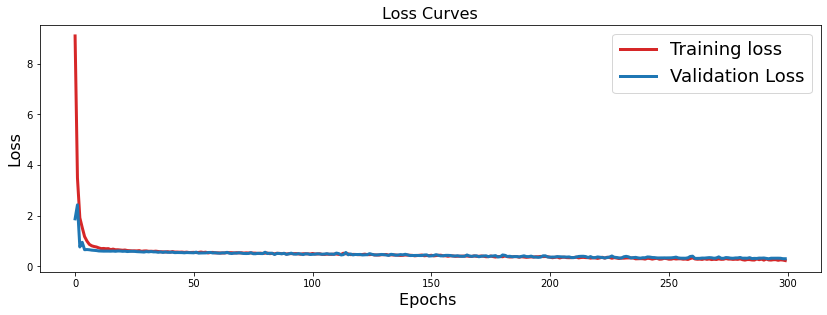

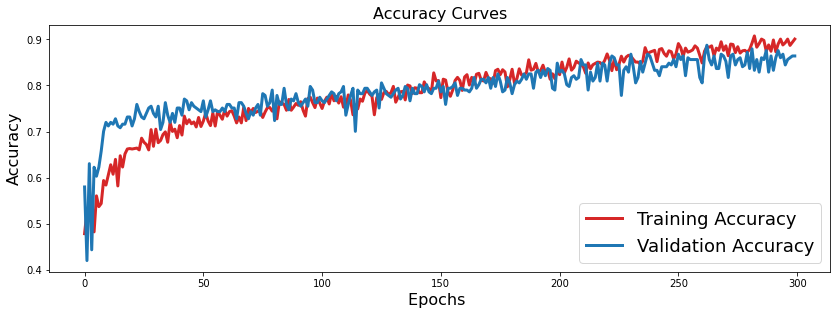

In [16]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [17]:
print(x_test.shape)
print(y_train.shape)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

(257, 40, 130, 1)
(1024, 2)
9/9 [==============================] - 0s 9ms/step - loss: 0.2956 - accuracy: 0.8638
Test loss: 0.29562869668006897
Test accuracy: 0.8638132214546204


In [18]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

9/9 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

    abnormal       0.85      0.83      0.84       111
      normal       0.87      0.89      0.88       146

    accuracy                           0.86       257
   macro avg       0.86      0.86      0.86       257
weighted avg       0.86      0.86      0.86       257



### Save Model and Weights

In [19]:
model_name = "heartbeat.h5"
model.save(model_name)

In [ ]:
# 1 sec overlap
# Trained for 3sec for files >3sec

### Classifying an heart beat

In [20]:
# load and evaluate a saved model
from keras.models import load_model
 
# load model
model = load_model("heartbeat_classifier.h5")

# File to be classified
classify_file = "c0001.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

1/1 [==============================] - 0s 4ms/step
[[0.9979917  0.00200832]]


In [21]:
pred_class = model.predict_classes(x_test)
if pred_class[0]:
    print("Normal heartbeat")
    print("confidence:",pred[0][1])
else:
    print("Abnormal heartbeat")
    print("confidence:",pred[0][0])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Abnormal heartbeat
confidence: 0.9979917
